<a href="https://colab.research.google.com/github/hugueds/tensorflow-course/blob/master/GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## GAN Generative Adversarial Networks

In [0]:
%tensorflow_version 2.x

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
sns.set()

In [0]:
from tensorflow.keras.datasets import mnist

In [6]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

11493376/11490434 [==============================] - 0s 0us/step


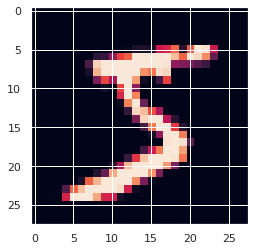

In [12]:
plt.imshow(X_train[0])

In [0]:
only_eights = X_train[y_train == 8]

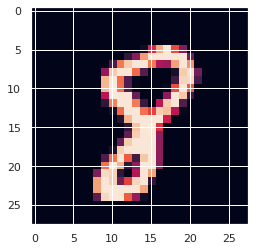

In [20]:
plt.imshow(only_eights[6])

In [0]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Reshape, Flatten, Dropout, LeakyReLU, BatchNormalization, Conv2D, Conv2DTranspose
from tensorflow.keras.models import Sequential

In [0]:
discriminator  = Sequential()
discriminator.add(Flatten(input_shape=[28,28]))
discriminator.add(Dense(150, activation='relu'))
discriminator.add(Dense(100, activation='relu'))
discriminator.add(Dense(1, activation='sigmoid'))

discriminator.compile(loss='binary_crossentropy', optimizer='adam')

In [0]:
coding_size = 100
generator = Sequential()
generator.add(Dense(100, activation='relu', input_shape=[coding_size]))
generator.add(Dense(150, activation='relu'))
generator.add(Dense(784, activation='relu'))
generator.add(Reshape([28, 28]))

In [0]:
GAN = Sequential([generator, discriminator])

In [0]:
discriminator.trainable = False

In [0]:
GAN.compile(loss='binary_crossentropy', optimizer='adam')

In [0]:
batch_size = 32

In [68]:
data = only_eights
data.shape

(5851, 28, 28)

In [0]:
dataset = None
dataset = tf.data.Dataset.from_tensor_slices(data).shuffle(buffer_size=1000)

In [0]:
dataset = dataset.batch(batch_size, drop_remainder=True).prefetch(1)

In [0]:
epochs = 10

In [0]:
_gen, _disc = GAN.layers

In [87]:
for epoch in range(epochs):

  print(f'Currently on epoch {epoch+1}')
  i = 0

  for X_batch in dataset:

    i += 1

    if i % 100 == 0:

      print(f'\t Currently batch number {i} of {len(data)//batch_size}')

    noise = tf.random.normal(shape=[batch_size, coding_size])

    gen_images = _gen(noise)

    X_fake_vs_real = tf.concat( [gen_images, tf.dtypes.cast(X_batch, tf.float32) ], axis=0)

    y1 = tf.constant( [[0.0]] * batch_size  + [[1.0]] * batch_size)

    discriminator.trainable = True
    discriminator.train_on_batch(X_fake_vs_real, y1)

    noise = tf.random.normal(shape=[batch_size, coding_size])

    y2 = tf.constant( [[1.0]] * batch_size )
    discriminator.trainable = False

    GAN.train_on_batch(noise, y2)


Currently on epoch 1
	 Currently batch number 100 of 182
Currently on epoch 2
	 Currently batch number 100 of 182
Currently on epoch 3
	 Currently batch number 100 of 182
Currently on epoch 4
	 Currently batch number 100 of 182
Currently on epoch 5
	 Currently batch number 100 of 182
Currently on epoch 6
	 Currently batch number 100 of 182
Currently on epoch 7
	 Currently batch number 100 of 182
Currently on epoch 8
	 Currently batch number 100 of 182
Currently on epoch 9
	 Currently batch number 100 of 182
Currently on epoch 10
	 Currently batch number 100 of 182


In [0]:
noise = tf.random.normal(shape=[10, coding_size])

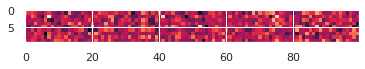

In [89]:
plt.imshow(noise)

In [0]:
images = generator(noise)

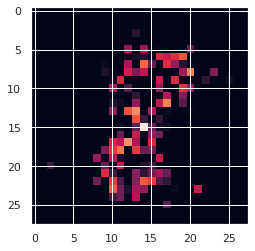

In [95]:
plt.imshow(images[5])

In [96]:
only_eights.max()

255

In [0]:
only_eights = only_eights / 255
only_eights * 2 - 1
only_eights = only_eights.reshape(-1,28,28,1 )

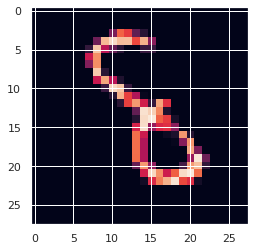

In [101]:
plt.imshow(only_eights[100])

In [0]:
np.random.seed(42)
tf.random.set_seed(42)

In [0]:
gen2 = Sequential()

In [0]:
gen2.add(Dense(7*7*128, input_shape=[coding_size]))
gen2.add(Reshape([7,7,128]))
gen2.add(BatchNormalization())
gen2.add(Conv2DTranspose(64, kernel_size=5, strides=2, padding='same', activation='relu'))
gen2.add(BatchNormalization())
gen2.add(Conv2DTranspose(1, kernel_size=5, strides=2, padding='same', activation='tanh'))

In [0]:
disc2 = Sequential()

In [0]:
disc2 = Sequential()
disc2.add(Conv2D(64, kernel_size=5, strides=2, padding="same",
                        activation=LeakyReLU(0.3),
                        input_shape=[28, 28, 1]))
disc2.add(Dropout(0.5))
disc2.add(Conv2D(128, kernel_size=5, strides=2, padding="same",
                        activation=LeakyReLU(0.3)))
disc2.add(Dropout(0.5))
disc2.add(Flatten())
disc2.add(Dense(1, activation="sigmoid"))

In [0]:
GAN = Sequential([gen2, disc2])

In [0]:
disc2.compile(loss="binary_crossentropy", optimizer="adam")
disc2.trainable = False

In [0]:
GAN.compile(loss="binary_crossentropy", optimizer="adam")

In [137]:
data = only_eights
print(data.shape)
dataset = None
dataset = tf.data.Dataset.from_tensor_slices(data).shuffle(buffer_size=1000)
dataset = dataset.batch(batch_size, drop_remainder=True).prefetch(1)

(5851, 28, 28, 1)


In [138]:
epochs = 20
dataset

<PrefetchDataset shapes: (32, 28, 28, 1), types: tf.float64>

In [139]:
# Grab the seprate components
gen2, disc2 = GAN.layers

# For every epcoh
for epoch in range(epochs):
    print(f"Currently on Epoch {epoch+1}")
    i = 0
    # For every batch in the dataset
    for X_batch in dataset:
        i=i+1
        if i%20 == 0:
            print(f"\tCurrently on batch number {i} of {len(data)//batch_size}")
        #####################################
        ## TRAINING THE DISCRIMINATOR ######
        ###################################
        
        # Create Noise
        noise = tf.random.normal(shape=[batch_size, coding_size])
        
        # Generate numbers based just on noise input
        gen_images = gen2(noise)       
        
        # Concatenate Generated Images against the Real Ones
        # TO use tf.concat, the data types must match!
        X_fake_vs_real = tf.concat([gen_images, tf.dtypes.cast(X_batch,tf.float32)], axis=0)
        
        # Targets set to zero for fake images and 1 for real images
        y1 = tf.constant([[0.]] * batch_size + [[1.]] * batch_size)
        
        # This gets rid of a Keras warning
        disc2.trainable = True
        
        # Train the discriminator on this batch
        disc2.train_on_batch(X_fake_vs_real, y1)
        
        
        #####################################
        ## TRAINING THE GENERATOR     ######
        ###################################
        
        # Create some noise
        noise = tf.random.normal(shape=[batch_size, coding_size])
        
        # We want discriminator to belive that fake images are real
        y2 = tf.constant([[1.]] * batch_size)
        
        # Avois a warning
        disc2.trainable = False
        
        GAN.train_on_batch(noise, y2)
        
print("TRAINING COMPLETE")            

Currently on Epoch 1
	Currently on batch number 20 of 182
	Currently on batch number 40 of 182
	Currently on batch number 60 of 182
	Currently on batch number 80 of 182
	Currently on batch number 100 of 182
	Currently on batch number 120 of 182
	Currently on batch number 140 of 182
	Currently on batch number 160 of 182
	Currently on batch number 180 of 182
Currently on Epoch 2
	Currently on batch number 20 of 182
	Currently on batch number 40 of 182
	Currently on batch number 60 of 182
	Currently on batch number 80 of 182
	Currently on batch number 100 of 182
	Currently on batch number 120 of 182
	Currently on batch number 140 of 182
	Currently on batch number 160 of 182
	Currently on batch number 180 of 182
Currently on Epoch 3
	Currently on batch number 20 of 182
	Currently on batch number 40 of 182
	Currently on batch number 60 of 182
	Currently on batch number 80 of 182
	Currently on batch number 100 of 182
	Currently on batch number 120 of 182
	Currently on batch number 140 of 182

In [0]:
noise = tf.random.normal(shape=[10, coding_size])

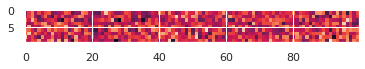

In [142]:
plt.imshow(noise)

In [0]:
single_image = images[0]

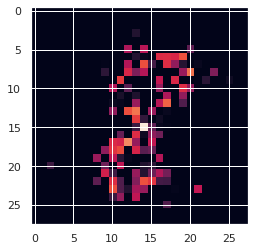

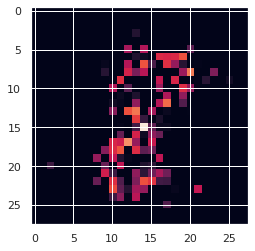

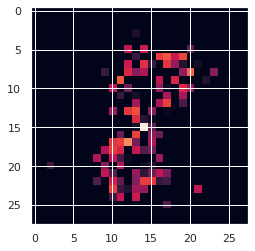

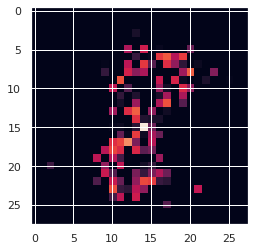

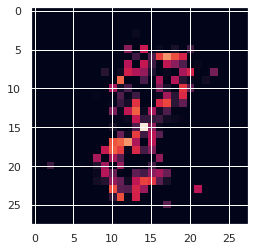

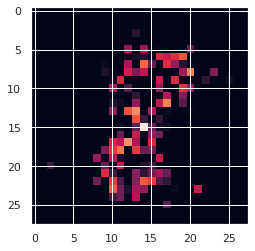

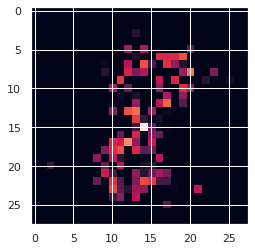

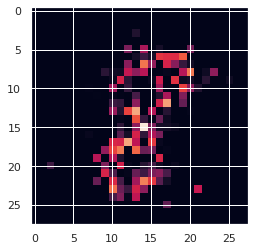

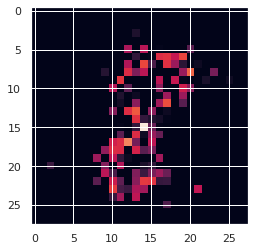

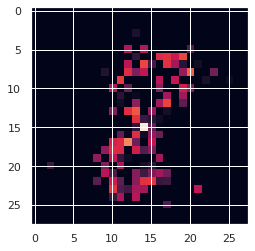

In [144]:
for image in images:
    plt.imshow(image.numpy().reshape(28,28))
    plt.show()